In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark as ps    # for the pyspark suite
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import IntegerType, StringType, FloatType, DateType, TimestampType
import pyspark.sql.functions as F

spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("trailrun") \
            .getOrCreate()
            
sc = spark.sparkContext   # for the pre-2.0 sparkContext

from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

### Run Data Prep File
* Creates DF from postgres database
* Cleans Data

In [131]:
run dataprep.py

In [132]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16978 entries, 0 to 16988
Data columns (total 27 columns):
PersonID             16978 non-null int64
EventID              16978 non-null int64
Gender               16978 non-null object
Distance             16978 non-null object
Total fee            16978 non-null float64
Payment method       13482 non-null object
Street Address       14062 non-null object
City                 15232 non-null object
State/Province       16087 non-null object
Zip Code             14978 non-null object
Country              15796 non-null object
Contact              16978 non-null object
Tshirt               16978 non-null object
Hoodie               16978 non-null object
Event_Name           16978 non-null object
Event_Date           16978 non-null datetime64[ns]
MergeoEvent          16978 non-null bool
EventTypeID          16978 non-null int64
EventType            16978 non-null object
SeriesID             16978 non-null float64
Age2                 16978

In [4]:
cleaned_df['SeriesID'].unique()

array([ 0.,  1.,  2.,  3.,  4.])

### Create Separate DFs for Event Info, Person Info, and Participations and Convert to Spark DFs

In [5]:
event_info = cleaned_df[['EventID', 'Distance', 'Event_Date', 'MergeoEvent', 'EventTypeID', 'EventType', 'Miles2', 
                         'SeriesID', 'HasSeries']]

In [6]:
spark_event_df = spark.createDataFrame(event_info)

In [7]:
person_info = cleaned_df[['PersonID', 'Gender', 'Total fee', 'Payment method', 'Street Address', 'City', 
                          'State/Province', 'Zip Code', 'Country', 'Contact', 'Tshirt', 'Hoodie', 'Age2', 'Time2', 
                          'Preregistered', 'has_emerg_contact', 'has_pay_method']]

In [8]:
spark_person_df = spark.createDataFrame(person_info)

In [9]:
participations = cleaned_df[['PersonID', 'EventID', 'Event_Date']].copy()

In [10]:
participated_list = np.full((16978, 1), 1)

participations.insert(2, 'Participated', participated_list)

In [11]:
spark_part_df = spark.createDataFrame(participations)

In [12]:
spark_part_df.show(5)
spark_part_df.printSchema()

+--------+-------+------------+-------------------+
|PersonID|EventID|Participated|         Event_Date|
+--------+-------+------------+-------------------+
|       1|     11|           1|1423958400000000000|
|       2|      9|           1|1422057600000000000|
|       2|     17|           1|1433808000000000000|
|       3|     30|           1|1446854400000000000|
|       4|     18|           1|1434758400000000000|
+--------+-------+------------+-------------------+
only showing top 5 rows

root
 |-- PersonID: long (nullable = true)
 |-- EventID: long (nullable = true)
 |-- Participated: long (nullable = true)
 |-- Event_Date: long (nullable = true)



### EDA On Participations Data

In [13]:
participations.count()

PersonID        16978
EventID         16978
Participated    16978
Event_Date      16978
dtype: int64

In [14]:
participations.head()

,PersonID,EventID,Participated,Event_Date
0,1,11,1,2015-02-15
1,2,9,1,2015-01-24
2,2,17,1,2015-06-09
3,3,30,1,2015-11-07
4,4,18,1,2015-06-20


In [15]:
unique_personIDs = participations['PersonID'].unique()
unique_eventIDs = participations['EventID'].unique()

In [16]:
print ('Total Number of Users: {}'.format(len(unique_personIDs)))
print ('Total Number of Events: {}'.format(len(unique_eventIDs)))
print ('Total Number of Participations {}'.format(len(participations)))

Total Number of Users: 10764
Total Number of Events: 86
Total Number of Participations 16978


In [17]:
print ('Total Possible Participations: {}'.format(10764 * 86))

Total Possible Participations: 925704


In [18]:
print ('Participant Sparsity: {}%'.format(round((1 - 16978 / 925704.)*100)))

Participant Sparsity: 98.0%


### Participation per Event EDA

In [19]:
part_per_event = participations.groupby('EventID')['Participated'].count()

In [20]:
print ('Min Event Size {}, Max Event Size {}'.format(
    min(part_per_event), max(part_per_event)))

Min Event Size 34, Max Event Size 592


In [21]:
participation_count = spark_part_df.groupBy("EventID").count().rdd.values().histogram(20)

In [22]:
participation_count

([34.0,
  61.9,
  89.8,
  117.69999999999999,
  145.6,
  173.5,
  201.39999999999998,
  229.29999999999998,
  257.2,
  285.1,
  313.0,
  340.9,
  368.79999999999995,
  396.7,
  424.59999999999997,
  452.5,
  480.4,
  508.29999999999995,
  536.2,
  564.1,
  592],
 [9, 7, 9, 10, 9, 3, 4, 10, 8, 4, 2, 7, 0, 1, 1, 0, 0, 0, 1, 1])

In [23]:
participation_count[0].pop(0)

print(len(participation_count[0]))
print(len(participation_count[1]))

20
20


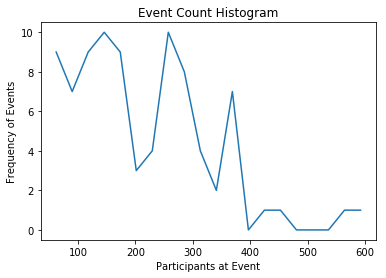

In [24]:
plt.plot(participation_count[0], participation_count[1])
plt.title("Event Count Histogram")
plt.xlabel("Participants at Event")
plt.ylabel("Frequency of Events")
plt.show()

In [25]:
best_events = spark_part_df.groupBy('EventID').count().join(spark_event_df, 'EventID')\
.select("EventID", "EventType", "count").distinct().orderBy('count', ascending=False).limit(20).show()

+-------+---------------+-----+
|EventID|      EventType|count|
+-------+---------------+-----+
|   1003|Street Scramble|  592|
|     68|      Trail Run|  560|
|   1009|Street Scramble|  439|
|     37|      Trail Run|  407|
|     12|      Trail Run|  354|
|     11|      Trail Run|  353|
|     38|      Trail Run|  353|
|     35|      Trail Run|  352|
|     69|      Trail Run|  349|
|     76|      Trail Run|  348|
|     36|      Trail Run|  341|
|     24|      Trail Run|  329|
|     16|      Trail Run|  323|
|     10|      Trail Run|  303|
|     63|      Trail Run|  301|
|     41|      Trail Run|  293|
|     54|      Trail Run|  292|
|     74|      Trail Run|  281|
|     50|      Trail Run|  280|
|     33|      Trail Run|  280|
+-------+---------------+-----+



### Events per Participant EDA

In [26]:
events_per_part = participations.groupby('PersonID')['Participated'].count()

In [27]:
print ('Min Participation Size {}, Max Participation Size {}'.format(
    min(events_per_part), max(events_per_part)))

Min Participation Size 1, Max Participation Size 50


In [28]:
event_count = spark_part_df.groupBy("PersonID").count().rdd.values().histogram(20)

In [29]:
event_count[0].pop(0)

print(len(event_count[0]))
print(len(event_count[1]))

20
20


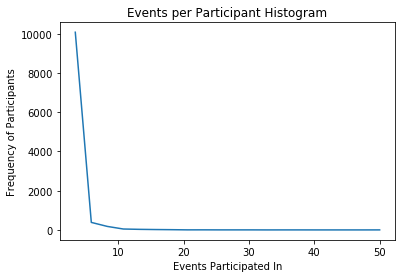

In [30]:
plt.plot(event_count[0], event_count[1])
plt.title("Events per Participant Histogram")
plt.xlabel("Events Participated In")
plt.ylabel("Frequency of Participants")
plt.show()

In [31]:
most_freq_participants = spark_part_df.groupBy('PersonID').count().join(spark_person_df, 'PersonID')\
.select("PersonID", "Gender", "count").distinct().orderBy('count', ascending=False).limit(20).show()

+--------+------+-----+
|PersonID|Gender|count|
+--------+------+-----+
|    1115|  Male|   50|
|    1910|  Male|   37|
|    1673|Female|   34|
|    1481|Female|   28|
|     729|Female|   28|
|     741|Female|   26|
|    3267|Female|   26|
|    1664|  Male|   25|
|    3056|  Male|   24|
|     149|  Male|   22|
|    1663|Female|   22|
|    4148|Female|   21|
|    1210|  Male|   21|
|    2980|Female|   20|
|    2798|Female|   20|
|    1551|Female|   20|
|    1393|Female|   18|
|    3463|  Male|   17|
|    2873|  Male|   17|
|     424|  Male|   17|
+--------+------+-----+



## Baseline Model

### Create Train/Validation/Test Split

In [32]:
print ('TrainVal Size: {}'.format(round(len(participations)*.8)))
print ('Test Size: {}'.format(round(len(participations)*.2)))
print ('Total Participations Size: {}'.format(len(participations)))

TrainVal Size: 13582.0
Test Size: 3396.0
Total Participations Size: 16978


Do an 80/20 split for train/test, then split train again at 80/20 for train/validate

In [33]:
trainval = spark_part_df.sort('Event_Date', ascending=True).limit(13582)
test = spark_part_df.sort('Event_Date', ascending=False).limit(3396)

In [34]:
trainval.count(), test.count()

(13582, 3396)

In [35]:
print ('Train Size: {}'.format(round(trainval.count() * .8)))
print ('Validation Size: {}'.format(round(trainval.count()*.2)))
print ('Total TrainVal Size: {}'.format(trainval.count()))

Train Size: 10866.0
Validation Size: 2716.0
Total TrainVal Size: 13582


In [36]:
train = trainval.sort('Event_Date', ascending=True).limit(10866)
validate = trainval.sort('Event_Date', ascending=False).limit(2716)

In [37]:
train.count(), validate.count()

(10866, 2716)

In [38]:
print("participants in train: {}".format(train.select('PersonID').distinct().count()))
print("participants in validate: {}".format(validate.select('PersonID').distinct().count()))
print("participants in test: {}".format(test.select('PersonID').distinct().count()))

print("participants in both train & validate: {}".format(train.select('PersonID').distinct()\
                                         .join(validate.select('PersonID').distinct(),
                                               'PersonID', 'inner')\
                                         .count()))

print("participants in both train & test: {}".format(train.select('PersonID').distinct()\
                                         .join(test.select('PersonID').distinct(),
                                               'PersonID', 'inner')\
                                         .count()))

print("events in train: {}".format(train.select('EventID').distinct().count()))
print("events in validate: {}".format(validate.select('EventID').distinct().count()))
print("events in test: {}".format(test.select('EventID').distinct().count()))

print("events in both train & validate: {}".format(train.select('EventID').distinct()\
                                         .join(validate.select('EventID').distinct(),
                                               'EventID', 'inner')\
                                         .count()))

print("events in both train & test: {}".format(train.select('EventID').distinct()\
                                         .join(test.select('EventID').distinct(),
                                               'EventID', 'inner')\
                                         .count()))

participants in train: 7356
participants in validate: 1996
participants in test: 2667
participants in both train & validate: 567
participants in both train & test: 618
events in train: 57
events in validate: 14
events in test: 17
events in both train & validate: 1
events in both train & test: 0


### Fit Initial ALS Model Out of the Box

In [39]:
als = ALS(rank=100,
          maxIter=10,
          regParam=0.1,
          userCol="PersonID",
          itemCol="EventID",
          ratingCol="Participated", nonnegative=True)

base_model = als.fit(train)

base_predictions = base_model.transform(validate)

In [40]:
base_predictions.show(5)

+--------+-------+------------+-------------------+----------+
|PersonID|EventID|Participated|         Event_Date|prediction|
+--------+-------+------------+-------------------+----------+
|     516|   4000|           1|1477785600000000000|       NaN|
|    7281|   4000|           1|1477785600000000000|       NaN|
|    6597|   4000|           1|1477785600000000000|       NaN|
|    6552|   4000|           1|1477785600000000000|       NaN|
|    7404|   4000|           1|1477785600000000000|       NaN|
+--------+-------+------------+-------------------+----------+
only showing top 5 rows



In [41]:
base_pred_pandas = base_predictions.toPandas()

In [42]:
base_pred_pandas[pd.notnull(base_pred_pandas['prediction'])]['Participated'].count()

79

In [43]:
base_pred_pandas[pd.isnull(base_pred_pandas['prediction'])]['Participated'].count()

2637

In [44]:
base_pred_pandas['prediction'].mean()

0.8971876743473585

In [45]:
#initial evaluation using RMSE (root-mean-squared-error)
#input average prediction value for all the NANs
base_evaluator = RegressionEvaluator(metricName="rmse", labelCol="Participated",
                                predictionCol="prediction")

rmse = base_evaluator.evaluate(base_predictions.na.fill({'prediction':base_pred_pandas['prediction'].mean()}))

print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.102813043463


### This is pretty poor:
* Only 79 predictions gave valid results; the other 2637 records in the validate dataset have predictions of NaN
* The RMSE is not a very useful measure at this point given most of the values had to be filled with the average prediction of .894, so of course our RMSE is low!
* Need to figure out how to address the NANs

### Try a test to increase rank (# of latent features considered), change implicitPrefs to True, and change cold start strategy to "drop":

In [46]:
als2 = ALS(rank=200,
          maxIter=10, #default
          regParam=0.1,
          userCol="PersonID",
          itemCol="EventID",
          ratingCol="Participated", 
          nonnegative=True,
          implicitPrefs=True,
          alpha=1.0, #default
          coldStartStrategy="drop")

v2_model = als2.fit(train)

v2_predictions = v2_model.transform(validate)

In [47]:
v2_predictions.show(5)

+--------+-------+------------+-------------------+------------+
|PersonID|EventID|Participated|         Event_Date|  prediction|
+--------+-------+------------+-------------------+------------+
|    4158|     54|           1|1472256000000000000|1.8660718E-4|
|    4219|     54|           1|1472256000000000000|         0.0|
|    3089|     54|           1|1472256000000000000| 0.010773112|
|    3220|     54|           1|1472256000000000000|0.0016633217|
|    1808|     54|           1|1472256000000000000| 0.008297206|
+--------+-------+------------+-------------------+------------+
only showing top 5 rows



In [48]:
v2_pred_pandas = v2_predictions.toPandas()

In [49]:
v2_pred_pandas[pd.notnull(v2_pred_pandas['prediction'])]['Participated'].count()

79

In [50]:
v2_pred_pandas[pd.isnull(v2_pred_pandas['prediction'])]['Participated'].count()

0

In [51]:
v2_pred_pandas['EventID'].unique()

array([54])

In [52]:
v2_pred_pandas['prediction'].mean()

0.3273853944792956

In [53]:
#initial evaluation using RMSE (root-mean-squared-error)
#don't need to address NANs since they have been dropped
v2_evaluator = RegressionEvaluator(metricName="rmse", labelCol="Participated",
                                predictionCol="prediction")

rmse = v2_evaluator.evaluate(v2_predictions)

print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.796373677994


### Still Not Great, and Dropping NANs for the ColdStartStrategy Meant Dropping 97% of the Test Data!
#### What's going on here?
* Because I'm attempting to predict participation at *future* events, we have a serious cold start problem.  The only reason the train / validate split didn't result in 100% NANs is because one event ID spanned the split so there were records in both train and validate.  All future events were not seen by the model during training, and as such all participants for those events that I'm trying to predict are going to return NANs
* Need to take a different approach to fit my model other than using unique event IDs...

### Consider other features in data that are repeatable such as venue, race type, series it belongs to, etc.  Build several ALS models and do an ensemble.

## First Do One Train/Validate/Test Split with All Columns (use same split for each of following models)

In [54]:
participated_list = np.full((16978, 1), 1)
cleaned_df.insert(2, 'Participated', participated_list)

In [55]:
spark_data_df = spark.createDataFrame(cleaned_df)

In [56]:
def train_val_test_split(spark_df, test_prop, val_prop):
    trainval = spark_df.sort('Event_Date', ascending=True).limit(int(round(spark_df.count()*(1-test_prop))))
    test = spark_df.sort('Event_Date', ascending=False).limit(int(round(spark_df.count()*test_prop)))
    train = trainval.sort('Event_Date', ascending=True).limit(int(round(trainval.count()*(1-val_prop))))
    validate = trainval.sort('Event_Date', ascending=False).limit(int(round(trainval.count()*(val_prop))))
    print('Train Size: {}'.format(round(train.count())))
    print('Validation Size: {}'.format(round(validate.count())))
    print('Test Size: {}'.format(round(test.count())))
    return train, validate, test

In [57]:
def print_train_val_test_info(event_param):
    print("participants in train: {}".format(train.select('PersonID').distinct().count()))
    print("participants in validate: {}".format(validate.select('PersonID').distinct().count()))
    print("participants in test: {}".format(test.select('PersonID').distinct().count()))
    print('\n')
    print("participants in both train & validate: {}".format(train.select('PersonID').distinct()\
                                         .join(validate.select('PersonID').distinct(),
                                               'PersonID', 'inner')\
                                         .count()))
    print("participants in both train & test: {}".format(train.select('PersonID').distinct()\
                                         .join(test.select('PersonID').distinct(),
                                               'PersonID', 'inner')\
                                         .count()))
    print('\n')
    print("{} in train: {}".format(event_param, train.select(event_param).distinct().count()))
    print("{} in validate: {}".format(event_param, validate.select(event_param).distinct().count()))
    print("{} in test: {}".format(event_param, test.select(event_param).distinct().count()))
    print('\n')
    print("{} in both train & validate: {}".format(event_param, train.select(event_param).distinct()\
                                         .join(validate.select(event_param).distinct(),
                                               event_param, 'inner')\
                                         .count()))
    print("{} in both train & test: {}".format(event_param, train.select(event_param).distinct()\
                                         .join(test.select(event_param).distinct(),
                                               event_param, 'inner')\
                                         .count()))

In [58]:
train, validate, test = train_val_test_split(spark_data_df, .2, .2)

Train Size: 10866.0
Validation Size: 2716.0
Test Size: 3396.0


## Define Functions for Repeat Use on Various Features

In [59]:
def create_participate_matrices(train, validate, test, event_param):
    train_mat = train.select("PersonID", event_param, "Participated", "Event_Date")
    validate_mat = validate.select("PersonID", event_param, "Participated", "Event_Date")
    test_mat = test.select("PersonID", event_param, "Participated", "Event_Date")
    return train_mat, validate_mat, test_mat

In [60]:
def fit_ALS(train_data, rank=100, maxIter=10, regParam=0.1, userCol="PersonID", itemCol="EventID", 
            ratingCol="Participated", implicitPrefs=False, alpha=1.0, coldStartStrategy="nan"):
    
    als = ALS(rank=rank,
          maxIter=maxIter,
          regParam=regParam,
          userCol=userCol,
          itemCol=itemCol,
          ratingCol=ratingCol,
            nonnegative=True,
             implicitPrefs=implicitPrefs,
             alpha=alpha,
             coldStartStrategy=coldStartStrategy)
    
    model = als.fit(train_data)
    
    return model

In [61]:
def predict_ALS(model, val_data):
                
    predictions = model.transform(val_data)
    
    pandas_preds = predictions.toPandas()
    valid_preds = pandas_preds[pd.notnull(pandas_preds['prediction'])]['Participated'].count()
    nan_preds = pandas_preds[pd.isnull(pandas_preds['prediction'])]['Participated'].count()
    print('Predictions includes {} valid values and {} nan values'.format(valid_preds, nan_preds))
    print('\n')
    print('Mean prediction is {}'.format(pandas_preds['prediction'].mean()))
    
    #initial evaluation using RMSE (root-mean-squared-error)
    #address nan values with mean prediction value (for cold starts) if coldStartStrategy is nan
    
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="Participated",
                                predictionCol="prediction")
    
    rmse = evaluator.evaluate(predictions.na.fill({'prediction':pandas_preds['prediction'].mean()}))

    print("Root-mean-square error = " + str(rmse))
    
    return predictions, rmse

## ALS Using Series Grouping

#### First try with parameters as initialized in function definition above

In [62]:
print_train_val_test_info('SeriesID')

participants in train: 7356
participants in validate: 1996
participants in test: 2667


participants in both train & validate: 567
participants in both train & test: 618


SeriesID in train: 5
SeriesID in validate: 3
SeriesID in test: 4


SeriesID in both train & validate: 3
SeriesID in both train & test: 4


In [63]:
train_series, validate_series, test_series = create_participate_matrices(train, validate, test, "SeriesID")

In [64]:
series_base_model = fit_ALS(train_series, itemCol="SeriesID")

In [65]:
series_base_preds, series_base_rmse = predict_ALS(series_base_model, validate_series)

Predictions includes 1005 valid values and 1711 nan values


Mean prediction is 0.896893754943
Root-mean-square error = 0.103749199179


#### Try with parameters varied as follows:
* implicitPrefs=True

In [66]:
series_v1_model = fit_ALS(train_series, itemCol="SeriesID", implicitPrefs=True)

In [67]:
series_v1_preds, series_v1_rmse = predict_ALS(series_v1_model, validate_series)

Predictions includes 1005 valid values and 1711 nan values


Mean prediction is 0.702169265608
Root-mean-square error = 0.458829067506


In [68]:
series_v1_preds_pandas = series_v1_preds.toPandas()

In [69]:
print '{} users in validation set that are not in training set, and they attended a total of {} events'.format(
    len(series_v1_preds_pandas[pd.isnull(series_v1_preds_pandas['prediction'])]['PersonID'].unique()),
    len(series_v1_preds_pandas[pd.isnull(series_v1_preds_pandas['prediction'])]['PersonID']))

1429 users in validation set that are not in training set, and they attended a total of 1711 events


#### Try with parameters varied as follows:
* coldStartStrategy="drop"

In [70]:
series_v2_model = fit_ALS(train_series, itemCol="SeriesID", coldStartStrategy="drop")

In [71]:
series_v2_preds, series_v2_rmse = predict_ALS(series_v2_model, validate_series)

Predictions includes 1005 valid values and 0 nan values


Mean prediction is 0.896893754943
Root-mean-square error = 0.104834724086


#### Perform Cross-Validation and Grid Search to Tune Hyperparameters

In [72]:
estimator=ALS(userCol="PersonID", itemCol="SeriesID", ratingCol="Participated", nonnegative=True, coldStartStrategy="drop")

grid=ParamGridBuilder().addGrid(als.rank, [10, 50, 100]).addGrid(als.maxIter, [10, 50]).addGrid(
    als.regParam, [0.1, 0.01]).addGrid(als.implicitPrefs, [True, False]).build()
        
evaluator=RegressionEvaluator(metricName="rmse", labelCol="Participated", predictionCol="prediction")

In [73]:
cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3)

In [74]:
model_series = cv.fit(train_series)

In [75]:
bestModel_series = model_series.bestModel

In [76]:
bestModel_series

ALS_448f9a78d9e6dceb3cfc

In [77]:
#model_series.getEstimatorParamMaps()

In [78]:
#model_series.avgMetrics

Looks like changing the parameters has no effect on the model performance...

In [79]:
bestModel_series._java_obj.getColdStartStrategy()

u'drop'

In [80]:
series_cv_preds, series_cv_rmse = predict_ALS(bestModel_series, validate_series)

Predictions includes 1005 valid values and 0 nan values


Mean prediction is 0.896242071325
Root-mean-square error = 0.110767284748


#### Try TrainValidationSplit instead of CrossValidator

In [81]:
tvs = TrainValidationSplit(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator)

In [82]:
tvs_model_series = tvs.fit(train_series)

In [83]:
tvs_bestmodel_series = tvs_model_series.bestModel

In [84]:
series_tvs_preds, series_tvs_rmse = predict_ALS(tvs_bestmodel_series, validate_series)

Predictions includes 1005 valid values and 0 nan values


Mean prediction is 0.896242071325
Root-mean-square error = 0.110767284748


Looks like using tvs instead of cv gives the same results; since tvs is less expensive I will just use that moving forward (will try cvs one more time to confirm consistency first)

## ALS Using Event Type ID

#### Try with parameters as defined in my fit function:

In [85]:
print_train_val_test_info('EventTypeID')

participants in train: 7356
participants in validate: 1996
participants in test: 2667


participants in both train & validate: 567
participants in both train & test: 618


EventTypeID in train: 2
EventTypeID in validate: 1
EventTypeID in test: 2


EventTypeID in both train & validate: 1
EventTypeID in both train & test: 2


In [86]:
train_eventtype, validate_eventtype, test_eventtype = create_participate_matrices(train, validate, test, "EventTypeID")

In [87]:
eventtype_base_model = fit_ALS(train_eventtype, itemCol="EventTypeID")

In [88]:
eventtype_base_preds, eventtype_base_rmse = predict_ALS(eventtype_base_model, validate_eventtype)

Predictions includes 1005 valid values and 1711 nan values


Mean prediction is 0.897703961769
Root-mean-square error = 0.103235677161


#### Perform Cross-Validation and Grid Search to Tune Hyperparameters; move this code into a function for future use

In [89]:
def run_ALS_CV(itemCol, train_data, val_data):
    
    estimator=ALS(userCol="PersonID", itemCol=itemCol, ratingCol="Participated", nonnegative=True, 
                  coldStartStrategy="drop")
    
    grid=ParamGridBuilder().addGrid(als.rank, [10, 50, 100]).addGrid(als.maxIter, [10, 50]).addGrid(
    als.regParam, [0.1, 0.01]).addGrid(als.implicitPrefs, [True, False]).build()
    
    evaluator=RegressionEvaluator(metricName="rmse", labelCol="Participated", predictionCol="prediction")
    
    cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3)
    
    cv_model = cv.fit(train_data)
    cv_bestmodel = cv_model.bestModel
    
    cv_preds, cv_rmse = predict_ALS(cv_bestmodel, val_data)
    
    return cv_bestmodel, cv_preds, cv_rmse

In [90]:
def run_ALS_TVS(itemCol, train_data, val_data):
    
    estimator=ALS(userCol="PersonID", itemCol=itemCol, ratingCol="Participated", nonnegative=True, 
                  coldStartStrategy="drop")
    
    grid=ParamGridBuilder().addGrid(als.rank, [10, 50, 100]).addGrid(als.maxIter, [10, 50]).addGrid(
    als.regParam, [0.1, 0.01]).addGrid(als.implicitPrefs, [True, False]).build()
    
    evaluator=RegressionEvaluator(metricName="rmse", labelCol="Participated", predictionCol="prediction")
    
    tvs = TrainValidationSplit(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator)
    
    tvs_model = tvs.fit(train_data)
    tvs_bestmodel = tvs_model.bestModel
    
    tvs_preds, tvs_rmse = predict_ALS(tvs_bestmodel, val_data)
    
    return tvs_bestmodel, tvs_preds, tvs_rmse

In [91]:
train_eventtype.show(5), validate_eventtype.show(5)

+--------+-----------+------------+-------------------+
|PersonID|EventTypeID|Participated|         Event_Date|
+--------+-----------+------------+-------------------+
|    5485|          2|           1|1418428800000000000|
|    5486|          2|           1|1418428800000000000|
|    5487|          2|           1|1418428800000000000|
|    5488|          2|           1|1418428800000000000|
|    5489|          2|           1|1418428800000000000|
+--------+-----------+------------+-------------------+
only showing top 5 rows

+--------+-----------+------------+-------------------+
|PersonID|EventTypeID|Participated|         Event_Date|
+--------+-----------+------------+-------------------+
|    3306|          1|           1|1487980800000000000|
|      13|          1|           1|1487980800000000000|
|      57|          1|           1|1487980800000000000|
|      68|          1|           1|1487980800000000000|
|     107|          1|           1|1487980800000000000|
+--------+-----------+-

(None, None)

In [92]:
bestmodel_eventtype, preds_eventtype, rmse_eventtype = run_ALS_TVS("EventTypeID", train_eventtype, validate_eventtype)

Predictions includes 1005 valid values and 0 nan values


Mean prediction is 0.898863590772
Root-mean-square error = 0.108081741943


In [93]:
run_ALS_CV("EventTypeID", train_eventtype, validate_eventtype)

Predictions includes 1005 valid values and 0 nan values


Mean prediction is 0.898863590772
Root-mean-square error = 0.108081741943


(ALS_4dfd81cc09f958c8b0ea,
 DataFrame[PersonID: bigint, EventTypeID: bigint, Participated: bigint, Event_Date: bigint, prediction: float],
 0.10808174194300368)

## ALS Using Miles (cleaner buckets than distance column)

In [94]:
print_train_val_test_info('Miles2')

participants in train: 7356
participants in validate: 1996
participants in test: 2667


participants in both train & validate: 567
participants in both train & test: 618


Miles2 in train: 17
Miles2 in validate: 15
Miles2 in test: 14


Miles2 in both train & validate: 13
Miles2 in both train & test: 14


In [95]:
train_miles, validate_miles, test_miles = create_participate_matrices(train, validate, test, "Miles2")

In [96]:
train_miles.toPandas()['Miles2'].unique()

#ALS only takes integers for the user/item columns so need to convert these

array([  8. ,   4. ,   3. ,   6. ,   5. ,  13. ,  20. ,  26. ,  10. ,
        50. ,  18. ,  30. ,   7.5,  63. ,   4.4,   2.5,   4.2])

In [97]:
train_miles_pandas = train_miles.toPandas()
val_miles_pandas = validate_miles.toPandas()
test_miles_pandas = test_miles.toPandas()

In [98]:
train_miles_pandas['Miles2'] = train_miles_pandas['Miles2'].apply(lambda x: int(round(x)))
val_miles_pandas['Miles2'] = val_miles_pandas['Miles2'].apply(lambda x: int(round(x)))
test_miles_pandas['Miles2'] = test_miles_pandas['Miles2'].apply(lambda x: int(round(x)))

In [99]:
train_miles_pandas['Miles2'].unique()

array([ 8,  4,  3,  6,  5, 13, 20, 26, 10, 50, 18, 30, 63])

In [100]:
train_miles = spark.createDataFrame(train_miles_pandas)
validate_miles = spark.createDataFrame(val_miles_pandas)
test_miles = spark.createDataFrame(test_miles_pandas)

In [101]:
miles_base_model = fit_ALS(train_miles, itemCol="Miles2")

In [102]:
miles_base_preds, miles_base_rmse = predict_ALS(miles_base_model, validate_miles)

Predictions includes 991 valid values and 1725 nan values


Mean prediction is 0.895499055549
Root-mean-square error = 0.104578199671


In [103]:
bestmodel_miles, preds_miles, rmse_miles = run_ALS_TVS("Miles2", train_miles, validate_miles)

Predictions includes 991 valid values and 0 nan values


Mean prediction is 0.896593409638
Root-mean-square error = 0.103840155906


## ALS Using Entry Fee

In [104]:
print_train_val_test_info('Total fee')

participants in train: 7356
participants in validate: 1996
participants in test: 2667


participants in both train & validate: 567
participants in both train & test: 618


Total fee in train: 326
Total fee in validate: 129
Total fee in test: 225


Total fee in both train & validate: 78
Total fee in both train & test: 94


In [105]:
train_fee, validate_fee, test_fee = create_participate_matrices(train, validate, test, "Total fee")

In [106]:
train_fee_pandas = train_fee.toPandas()
val_fee_pandas = validate_fee.toPandas()
test_fee_pandas = test_fee.toPandas()

In [107]:
train_fee_pandas['Total fee'] = train_fee_pandas['Total fee'].apply(lambda x: int(round(x)))
val_fee_pandas['Total fee'] = val_fee_pandas['Total fee'].apply(lambda x: int(round(x)))
test_fee_pandas['Total fee'] = test_fee_pandas['Total fee'].apply(lambda x: int(round(x)))

In [108]:
train_fee = spark.createDataFrame(train_fee_pandas)
validate_fee = spark.createDataFrame(val_fee_pandas)
test_fee = spark.createDataFrame(test_fee_pandas)

In [109]:
fee_base_model = fit_ALS(train_fee, itemCol="Total fee")

In [110]:
fee_base_preds, fee_base_rmse = predict_ALS(fee_base_model, validate_fee)

Predictions includes 1004 valid values and 1712 nan values


Mean prediction is 0.891526205517
Root-mean-square error = 0.110121949296


In [111]:
bestmodel_fee, preds_fee, rmse_fee = run_ALS_TVS("Total fee", train_fee, validate_fee)

Predictions includes 1004 valid values and 0 nan values


Mean prediction is 0.892026481579
Root-mean-square error = 0.111890641139


## ALS Using Venue Zip Code
#### Can try specific venues as well - may be too little repeatability though, hence starting with zip codes
#### Doing this one requires adding venue information to the dataset

In [147]:
event_names = list(cleaned_df['Event_Name'].unique())

In [148]:
event_venues = ["Fort Ebey State Park, Coupeville, WA", "Interlaken Park, Seattle, WA", "Ravenna Park, Seattle, WA",
               "Carkeek Park, Seattle, WA", "Rattlesnake Ridge, North Bend, WA", "Cedar Mountain, Renton, WA", 
               "Tiger Mountain, Issaquah, WA", "Redmond Watershed, Redmond, WA", "Interlaken Park, Seattle, WA", 
               "Ravenna Park, Seattle, WA", "Carkeek Park, Seattle, WA", "Seward Park, Seattle, WA", 
               "Soaring Eagle Regional Park, Sammamish, WA", "Redmond Watershed, Redmond, WA", 
               "Soaring Eagle Regional Park, Sammamish, WA", "St. Edward State Park, Kenmore, WA", 
               "Redmond Watershed, Redmond, WA", "Carkeek Park, Seattle, WA", "Lake Sammamish State Park, Issaquah, WA", 
               "Seward Park, Seattle, WA", "Cle Elum, WA", "St. Edward State Park, Kenmore, WA", 
               "St. Edward State Park, Kenmore, WA", "Pike Place Market, Seattle, WA", 
               "Lord Hill Regional Park, Snohomish, WA", "Gig Harbor, WA", "Landsburg Park, Maple Valley, WA", 
               "Redmond Watershed, Redmond, WA", "Sprague, WA", "Paradise Valley Conservation Area, Woodinville, WA", 
                "Wilburton Hill Park, Bellevue, WA", "Woodland Park, Seattle, WA", "Seward Park, Seattle, WA", 
                "Cougar Mountain Trailhead, Bellevue, WA", "Alki Beach, West Seattle, WA", "Kirkland, WA", 
                "Pike Place Market, Seattle, WA", "Redmond, WA", "Fremont, Seattle, WA", "Gig Harbor, WA", 
                "Issaquah, WA", "Cle Elum-Roslyn High School, Cle Elum, WA", "Interlaken Park, Seattle, WA", 
                "Everett, WA", "Fremont, Seattle, WA", "Ballard, Seattle, WA"]

In [149]:
len(event_names), len(event_venues)

(46, 46)

In [150]:
event_nm_ven = zip(event_names, event_venues)

In [113]:
import geocoder

In [157]:
g = geocoder.google("Pike Place Market, WA")

In [158]:
g.postal

In [153]:
event_dets = []
for name, venue in event_nm_ven:
    g = geocoder.google(venue)
    zipcode = g.postal
    event_dets.append((name, venue, g, zipcode))

In [156]:
msg_zip = []
for name, venue, g, zipcode in event_dets:
    if zipcode == None:
        msg_zip.append((venue, zipcode))
        
msg_zip

[('Pike Place Market, Seattle, WA', None),
 ('Gig Harbor, WA', None),
 ('Kirkland, WA', None),
 ('Pike Place Market, Seattle, WA', None),
 ('Redmond, WA', None),
 ('Fremont, Seattle, WA', None),
 ('Gig Harbor, WA', None),
 ('Issaquah, WA', None),
 ('Everett, WA', None),
 ('Fremont, Seattle, WA', None),
 ('Ballard, Seattle, WA', None)]

## ALS Using Race Elevation Gain